<a href="https://colab.research.google.com/github/nasirbashak/Plant-the-future/blob/master/LSTM_Bidirectional_model_for_Traffic_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0.0b1
!pip install tensorflow==2.1.0

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.1.0


In [0]:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-03-04 08:39:42--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.03s   

2020-03-04 08:39:43 (2.39 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



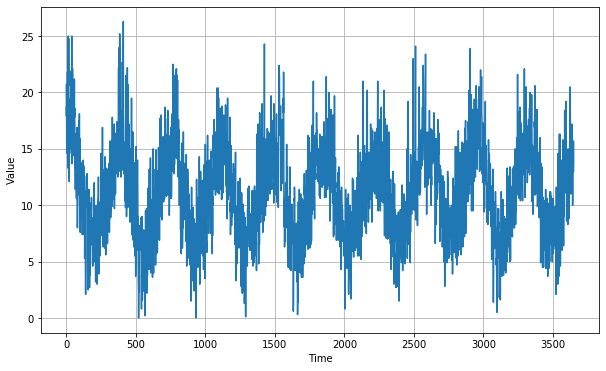

In [0]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1


series = np.array(temps)
time = np.array(time_step)



In [0]:
df = pd.read_csv('TrafficDensity2000to2019.csv')
df.head()

,Unnamed: 0,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,0,18018,43257,4364,9948,15486,10824,11394,62040,139362,222630,252997,275822,341228,418053,456370,458760,436913,383336,366666,360215
1,1,199759,206274,197413,224211,246554,253461,268019,285571,321176,305794,302507,306456,316183,312025,321552,304690,347855,351027,402511,430174
2,2,31975,18508,50090,33138,3230,40469,77694,91859,95982,68764,32090,3793,36285,51176,27385,645,20132,61869,123441,138125
3,3,143344,202934,239277,261303,290123,294132,292993,300010,288019,267043,214461,176663,106045,39201,64827,111801,180004,222712,251049,263517
4,4,13344,132736,256770,326341,373479,400300,339817,354813,290336,246211,191379,169207,44706,96832,217791,297401,378743,428859,435385,477570


In [0]:
df[["Unnamed: 0"]]
df.drop(columns=["Unnamed: 0"],axis=1,inplace=True)
df.head()

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,18018,43257,4364,9948,15486,10824,11394,62040,139362,222630,252997,275822,341228,418053,456370,458760,436913,383336,366666,360215
1,199759,206274,197413,224211,246554,253461,268019,285571,321176,305794,302507,306456,316183,312025,321552,304690,347855,351027,402511,430174
2,31975,18508,50090,33138,3230,40469,77694,91859,95982,68764,32090,3793,36285,51176,27385,645,20132,61869,123441,138125
3,143344,202934,239277,261303,290123,294132,292993,300010,288019,267043,214461,176663,106045,39201,64827,111801,180004,222712,251049,263517
4,13344,132736,256770,326341,373479,400300,339817,354813,290336,246211,191379,169207,44706,96832,217791,297401,378743,428859,435385,477570


In [0]:
time = np.array(range(len(df.columns)))
print(time[:10],time.shape)
series = np.array(df.iloc[699,:])
print(series[:10],series.shape)



[0 1 2 3 4 5 6 7 8 9] (20,)
[ 89793 113714  96397 101829 104212 111974 121932 118847 115671  95073] (20,)


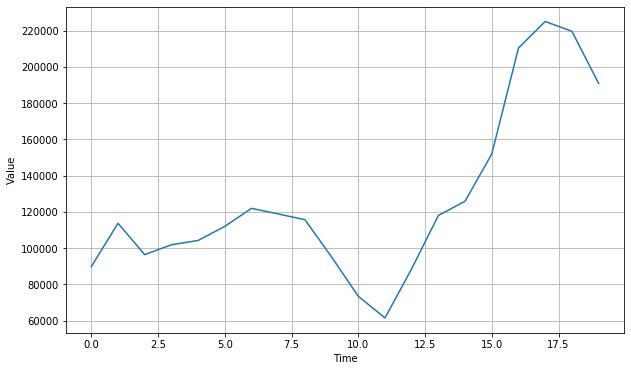

In [0]:

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 20
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 3
batch_size = 3
shuffle_buffer_size = 10



In [0]:

#normalizing data
# Z-Score scaling or Standard Scaling
# Output range [-3 to +3]
def norm(x):
  return (x - x.mean()) / x.std(), x.mean(), x.std()

  
normed_train_data, normed_train_mean, normed_train_std = norm(x_train)
normed_valid_data, normed_valid_mean, normed_valid_std = norm(x_valid)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
normed_train_data

array([-0.79051654, -0.27861025, -0.6491918 , -0.5329477 , -0.48195181,
       -0.31584603, -0.10274612, -0.16876472, -0.23673071, -0.67752522,
       -1.1409822 , -1.39688184, -0.81534038, -0.18648381, -0.01866604,
        0.53978496,  1.78953735,  2.10323804,  1.98729355,  1.37333129])

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(3).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 3
batch_size = 3
train_set = windowed_dataset(normed_train_data, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(normed_train_data.shape)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=3, kernel_size=2,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  
  tf.keras.layers.LSTM(3, return_sequences=True,input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=False)),
  #tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(20,)
Epoch 1/100
6/6 [==============================] - 3s 560ms/step - loss: 1.3484 - mae: 1.8091
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 1.3385 - mae: 1.8044
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2969 - mae: 1.7959
Epoch 4/100
6/6 [==============================] - 0s 12ms/step - loss: 1.2893 - mae: 1.7855
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 1.3190 - mae: 1.7724
Epoch 6/100
6/6 [==============================] - 0s 13ms/step - loss: 1.2851 - mae: 1.7583
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2659 - mae: 1.7412
Epoch 8/100
6/6 [==============================] - 0s 12ms/step - loss: 1.2257 - mae: 1.7229
Epoch 9/100
6/6 [==============================] - 0s 12ms/step - loss: 1.2448 - mae: 1.7014
Epoch 10/100
6/6 [==============================] - 0s 11ms/st

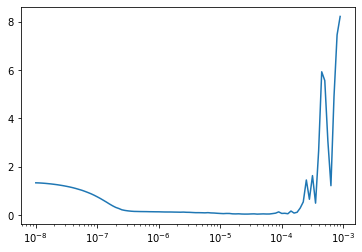

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-3, 100000, 140000])

In [0]:
bestLr = history.history["lr"][np.argmin(history.history["loss"])]
bestLr

3.981072e-05

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(normed_train_data, window_size=3, batch_size=3, shuffle_buffer=shuffle_buffer_size)


model = tf.keras.models.Sequential([
  #tf.keras.layers.Conv1D(filters=60, kernel_size=5,strides=1, padding="causal",activation="relu",input_shape=[None, 1]),
  #tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(3, return_sequences=True,input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(6, return_sequences=False)),
  #tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr=bestLr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 3)           60        
_________________________________________________________________
bidirectional (Bidirectional (None, 12)                480       
_________________________________________________________________
dense (Dense)                (None, 10)                130       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 681
Trainable params: 681
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(train_set,epochs=250)

Epoch 1/250
6/6 [==============================] - 3s 568ms/step - loss: 0.8487 - mae: 1.2055
Epoch 2/250
6/6 [==============================] - 0s 12ms/step - loss: 0.9823 - mae: 1.4486
Epoch 3/250
6/6 [==============================] - 0s 11ms/step - loss: 0.5166 - mae: 0.9485
Epoch 4/250
6/6 [==============================] - 0s 13ms/step - loss: 0.3560 - mae: 0.7373
Epoch 5/250
6/6 [==============================] - 0s 13ms/step - loss: 0.2437 - mae: 0.5912
Epoch 6/250
6/6 [==============================] - 0s 12ms/step - loss: 0.2176 - mae: 0.5210
Epoch 7/250
6/6 [==============================] - 0s 11ms/step - loss: 0.4036 - mae: 0.8430
Epoch 8/250
6/6 [==============================] - 0s 12ms/step - loss: 0.4198 - mae: 0.8357
Epoch 9/250
6/6 [==============================] - 0s 12ms/step - loss: 0.2829 - mae: 0.6756
Epoch 10/250
6/6 [==============================] - 0s 11ms/step - loss: 0.2671 - mae: 0.6119
Epoch 11/250
6/6 [==============================] - 0s 11ms/step - l

In [0]:

norm_series_data, norm_series_mean, norm_series_std = norm(series)
norm_series_data

array([-0.79051654, -0.27861025, -0.6491918 , -0.5329477 , -0.48195181,
       -0.31584603, -0.10274612, -0.16876472, -0.23673071, -0.67752522,
       -1.1409822 , -1.39688184, -0.81534038, -0.18648381, -0.01866604,
        0.53978496,  1.78953735,  2.10323804,  1.98729355,  1.37333129])

In [0]:
rnn_forecast = model_forecast(model, norm_series_data[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[ 0:-1, -1]
#rnn_forecast = rnn_forecast[:-1, -1]
print(rnn_forecast.shape)

rnn_forecast

(18, 1)
(17,)


array([-0.34576944, -0.13533337, -0.34888396, -0.23490712, -0.06594379,
        0.08689603,  0.17561512,  0.03477102, -0.1372652 , -0.5647608 ,
       -0.85048944, -0.6205211 , -0.20610951,  0.39758804,  1.1636962 ,
        1.3805166 ,  1.5730176 ], dtype=float32)

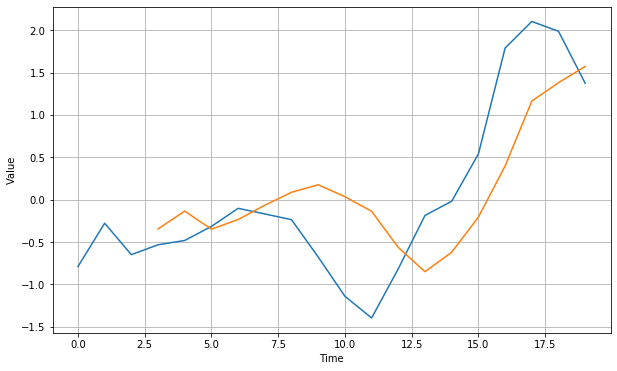

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_train, normed_train_data)
plot_series(time_train[3:], rnn_forecast)

In [0]:
tf.keras.metrics.mean_absolute_error(normed_train_data[3:], rnn_forecast).numpy()

0.57730836

In [0]:
print(rnn_forecast)

[-0.34576944 -0.13533337 -0.34888396 -0.23490712 -0.06594379  0.08689603
  0.17561512  0.03477102 -0.1372652  -0.5647608  -0.85048944 -0.6205211
 -0.20610951  0.39758804  1.1636962   1.3805166   1.5730176 ]


In [0]:
# x = y* Sigma + mean
print(norm_series_mean)
print(normed_train_mean)

original_series = rnn_forecast * normed_train_std+ normed_train_mean
print("Forecasted Series",original_series)
print("Series",x_train[3:])

126733.25
126733.25
Forecasted Series [110575.7   120409.22  110430.164 115756.22  123651.74  130793.836
 134939.61  128358.07  120318.945 100342.4    86990.516  97736.76
 117101.91  145312.25  181111.9   191243.77  200239.19 ]
Series [101829 104212 111974 121932 118847 115671  95073  73416  61458  88633
 118019 125861 151957 210357 225016 219598 190908]


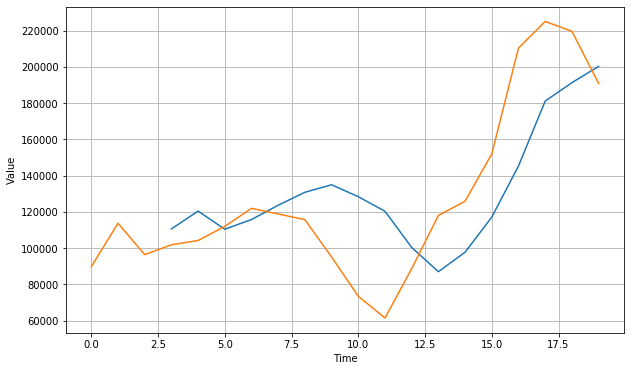

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_train[3:], original_series)
plot_series(time_train, series)

In [0]:
print(normed_train_data[3:])

[-1.17205254 -1.14030264 -1.16703035 -1.16376248 -0.87340399 -0.43010936
  0.04727427  0.22137126  0.35222923  0.72720826  1.16765354  1.38732866
  1.40103077  1.27577977  0.96861756  0.87304681  0.8360626 ]


In [0]:
model.save("LSTM_Bidirectional_model.h5")

In [0]:
model = tf.keras.models.load_model("LSTM_Bidirectional_model.h5")

In [0]:
time = np.array(range(len(df.columns)))
print(time[:10],time.shape)
series = np.array(df.iloc[0,:])
print(series[:10],series.shape)

[0 1 2 3 4 5 6 7 8 9] (20,)
[ 18018  43257   4364   9948  15486  10824  11394  62040 139362 222630] (20,)


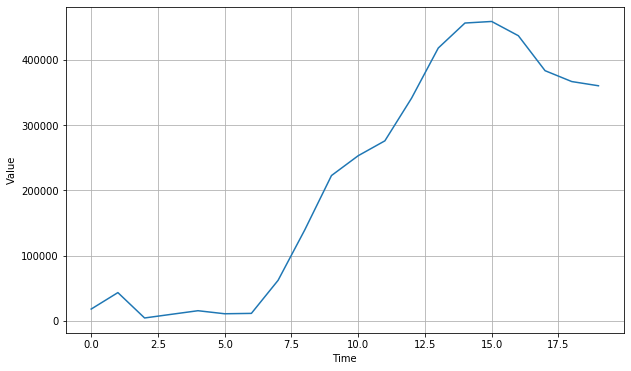

In [0]:

plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 20
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
norm_series_data, norm_series_mean, norm_series_std = norm(series)
norm_series_data

array([-1.12578644, -0.98108877, -1.20406616, -1.17205254, -1.14030264,
       -1.16703035, -1.16376248, -0.87340399, -0.43010936,  0.04727427,
        0.22137126,  0.35222923,  0.72720826,  1.16765354,  1.38732866,
        1.40103077,  1.27577977,  0.96861756,  0.87304681,  0.8360626 ])

In [0]:
normed_train_data, normed_train_mean, normed_train_std = norm(x_train)
normed_valid_data, normed_valid_mean, normed_valid_std = norm(x_valid)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
rnn_forecast = model_forecast(model, norm_series_data[..., np.newaxis], window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[ 0:-1, -1]
#rnn_forecast = rnn_forecast[:-1, -1]
print(rnn_forecast.shape)

(18, 1)
(17,)


In [0]:
# x = y* Sigma + mean
print(norm_series_mean)
print(normed_train_mean)

original_series = rnn_forecast * normed_train_std+ normed_train_mean
print("Forecasted Series",original_series)
print("Series",x_train[3:])

214384.15
214384.15
Forecasted Series [ 71481.19   70145.14   45248.64   50162.016  51761.906  76071.31
 105260.62  157681.6   246982.1   330314.53  398709.78  421685.3
 442342.06  459701.78  465130.44  459560.9   448686.88 ]
Series [  9948  15486  10824  11394  62040 139362 222630 252997 275822 341228
 418053 456370 458760 436913 383336 366666 360215]


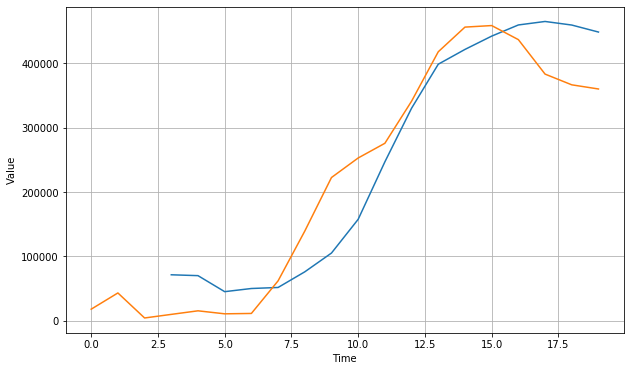

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_train[3:], original_series)
plot_series(time_train, series)

### Future predictions

In [0]:
print("Length of time steps",len(time))
print("Length of temperature",len(series))

Length of time steps 20
Length of temperature 20


In [0]:
time_copy = time[:]
series_copy = series[:]
print("Length of time steps",len(time_copy))
print("Length of temperature",len(series_copy))
series

Length of time steps 20
Length of temperature 20


array([ 18018,  43257,   4364,   9948,  15486,  10824,  11394,  62040,
       139362, 222630, 252997, 275822, 341228, 418053, 456370, 458760,
       436913, 383336, 366666, 360215])

In [0]:
#f = model_forecast(model, series_copy[3650-64:4652][..., np.newaxis], window_size)
f = model_forecast(model, series[0:3][...,np.newaxis], window_size)
print(f.shape)


(1, 1)


In [0]:
f[0][-1]

2.7380264

In [0]:
norm_series_data[3]

-1.1720525415800396

In [0]:
series_copy = np.append(series_copy,f[0][-1][0])

In [0]:
f = model_forecast(model, series_copy[3651-64:3651][...,np.newaxis], window_size)
print(f.shape)

(1, 64, 1)


In [0]:
f[0][-1][0]

13.834497

In [0]:
#print(f[0][-1],f[1][-1],f[2][-1])


In [0]:
print(series[3649])#,series[65],series[66])

13.0


In [0]:

print("Series ",series.shape)
forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("Total Forecast ",forecast.shape)
forecast = forecast[:-1, -1, 0][:-1]
#rnn_forecast = rnn_forecast[:-1, -1, 0]
print("Forecast ",forecast.shape)
print("Time ",time.shape)
time_forcasted = time[window_size:-1]
print("Time Forecasted",time_forcasted.shape)


Series  (3650,)
Total Forecast  (3587, 64, 1)
Forecast  (3585,)
Time  (3650,)
Time Forecasted (3585,)


In [0]:
time[:window_size+1][-1]
time_forcasted[0]

64

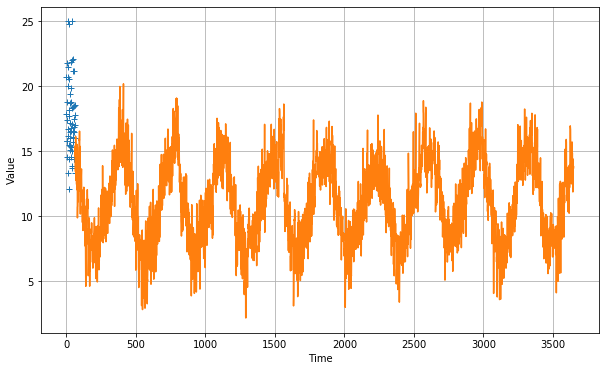

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time[:window_size], series[:window_size],format='+')
plot_series(time_forcasted, forecast,format='-')

In [0]:
print("Length of temperature",len(series_copy))


Length of temperature 3650


In [0]:
6400+3586

9986

In [0]:
(3649-(0)) % window_size

1

In [0]:
(3649-(0)) / window_size

57.015625